In [43]:
import multiprocessing
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
%matplotlib inline

from prophet import Prophet

In [2]:
multiprocessing.set_start_method("fork")
%load_ext autoreload
%autoreload 1

In [3]:
%aimport prophet_projpred
%aimport prophet_projpred.models
%aimport prophet_projpred.family
%aimport prophet_projpred.stats
%aimport prophet_projpred.plots

Reading the preprocessed dataset and selecting a subset to use. The following subset was selected:

| Dimension | Subset |
|-------|-------|
| date  | 2015-05-01 to 2017-06-30  |
|  city |  Quito  |
| categories |BEVERAGES, BREAD/BAKERY, CLEANING, |
|        | DELI,GROCERY I, MEATS, |
|        | PERSONAL CARE, POULTRY, PRODUCE|

The data was split to training and test sections in order to evaluate predictive performance. The split was made at 2017-05-01, leaving two months of data for testing forecasting performance.

In [4]:
df = pd.read_csv('data/ecuador_dataset.csv')
df['date']=pd.to_datetime(df['date'])
df = df.loc[
    df['family'].isin(
        ['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DELI', 'GROCERY I', 'MEATS', 'PERSONAL CARE', 'POULTRY', 'PRODUCE']),
    ['family', 'date', 'unit_sales', 'onpromotion', 'oil_price', 'precipitation', 
     'tavg', 'tmax', 'tmin', 'yellow maize', 'potatoes']
]
df = df.groupby(by='date').agg(
    unit_sales = pd.NamedAgg(column='unit_sales', aggfunc='sum'),
    onpromotion = pd.NamedAgg(column='onpromotion', aggfunc='sum'),
    oil_price = pd.NamedAgg(column='oil_price', aggfunc='first'),
    precipitation = pd.NamedAgg(column='precipitation', aggfunc='first'),
    tmax = pd.NamedAgg(column='tmax', aggfunc='first'),
    tmin = pd.NamedAgg(column='tmin', aggfunc='first'),
    tavg = pd.NamedAgg(column='tavg', aggfunc='first'),
    yellow_maize = pd.NamedAgg(column='yellow maize', aggfunc='first'),
    potatoes = pd.NamedAgg(column='potatoes', aggfunc='first')
)
df = df.rename(columns={'unit_sales': 'y'})
df = df.rename_axis('ds')
df[['y', 'onpromotion']] = np.log(df[['y', 'onpromotion']])

train = df.loc['2015-05-01':'2017-04-30',:].reset_index()
future = df.loc['2015-05-01':'2017-06-30',:].reset_index()

future

,ds,y,onpromotion,oil_price,precipitation,tmax,tmin,tavg,yellow_maize,potatoes
0,2015-05-01,12.508238,7.664816,59.10,0.0,20.300000,4.066667,13.950000,21.766667,0.295333
1,2015-05-02,12.606216,6.190315,59.10,0.0,21.000000,3.700000,13.400000,21.783333,0.295667
2,2015-05-03,12.677281,6.180017,59.10,20.1,21.000000,6.000000,11.300000,21.800000,0.296000
3,2015-05-04,12.323003,6.068426,58.92,16.0,19.000000,5.300000,12.100000,21.816667,0.296333
4,2015-05-05,12.197967,6.059123,60.38,8.9,20.100000,6.800000,11.900000,21.833333,0.296667
...,...,...,...,...,...,...,...,...,...,...
783,2017-06-26,12.583300,7.859027,43.24,0.0,18.520000,7.000000,12.920000,17.961667,0.274667
784,2017-06-27,12.430620,8.023880,44.25,0.0,18.466667,7.066667,12.933333,17.990000,0.276000
785,2017-06-28,12.574611,8.740177,44.74,0.0,18.413333,7.133333,12.946667,18.018333,0.277333
786,2017-06-29,12.367607,8.013674,44.88,0.0,18.360000,7.200000,12.960000,18.046667,0.278667


The dataset includes a list of local holidays. Only national holidays and local holidays in Quito were used to match the previously described data selection.

It is worth noting that the 30 days including and after the earthquake in 2016 were also included as holidays. Therefore the model is able to handle any anomalies during that time period.

In [5]:
holidays = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])
holidays = holidays[holidays['locale_name'].isin(['Quito', 'Ecuador'])]
holidays = holidays.sort_values(by=['description', 'date']).reset_index()
holidays = holidays[['date', 'description']].rename(columns={'date': 'ds', 'description': 'holiday'})
holidays

,ds,holiday
0,2013-05-24,Batalla de Pichincha
1,2014-05-24,Batalla de Pichincha
2,2015-05-24,Batalla de Pichincha
3,2016-05-24,Batalla de Pichincha
4,2017-05-24,Batalla de Pichincha
...,...,...
182,2013-04-29,Viernes Santo
183,2014-04-18,Viernes Santo
184,2015-04-03,Viernes Santo
185,2016-03-25,Viernes Santo


In [91]:
m = prophet_projpred.ReferenceModel(changepoint_prior_scale=0.01, 
                                    changepoint_range=0.8,
                                    holidays=holidays, 
                                    mcmc_samples=400, 
                                    uncertainty_samples=800, 
                                    n_changepoints=6)

In [92]:
m.add_seasonality(name='yearly', period=365.25, fourier_order=8, prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=8, prior_scale=10)
m.add_seasonality(name='weekly', period=7, fourier_order=5, prior_scale=10)
m.add_regressor('onpromotion')
m.add_regressor('oil_price')
m.add_regressor('precipitation')
m.add_regressor('tavg')
m.add_regressor('tmax')
m.add_regressor('tmin')
m.add_regressor('potatoes')
m.add_regressor('yellow_maize')

In [8]:
import os
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

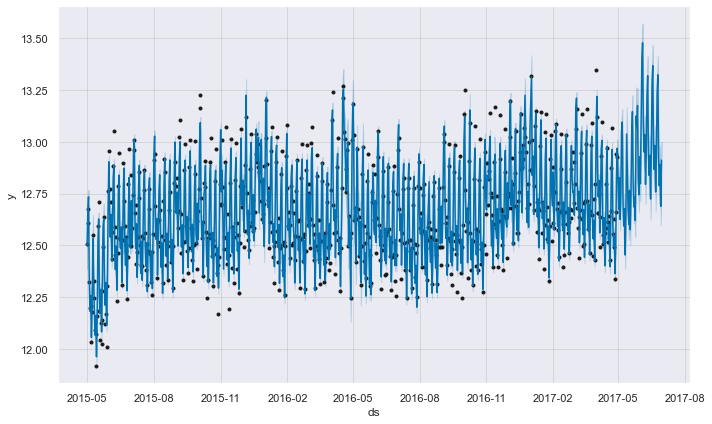

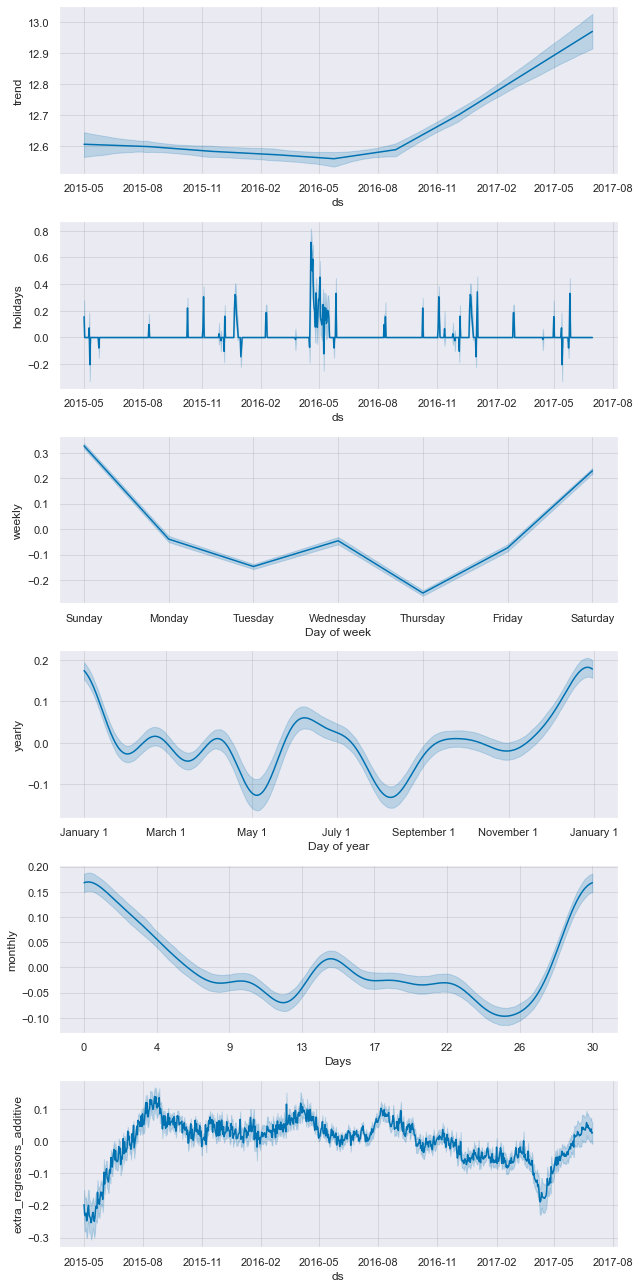

In [93]:
with suppress_stdout_stderr():
    m.fit(train)
forecast = m.predict(future)

fig1, ax = plt.subplots(figsize=(10,6))


fig1 = m.plot(forecast, ax=ax)
fig2 = m.plot_components(forecast)

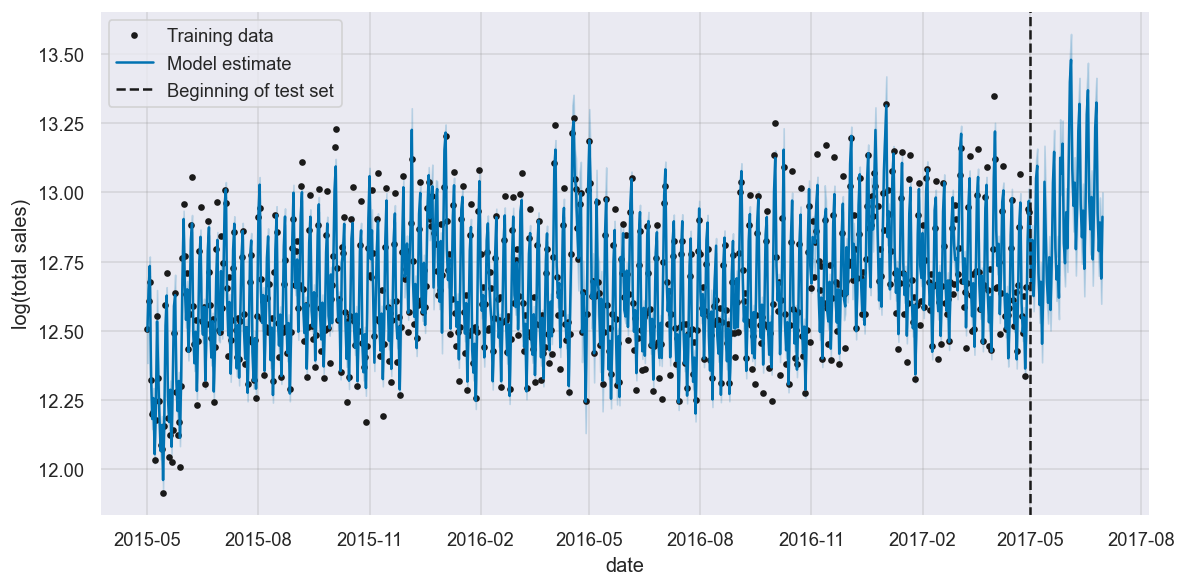

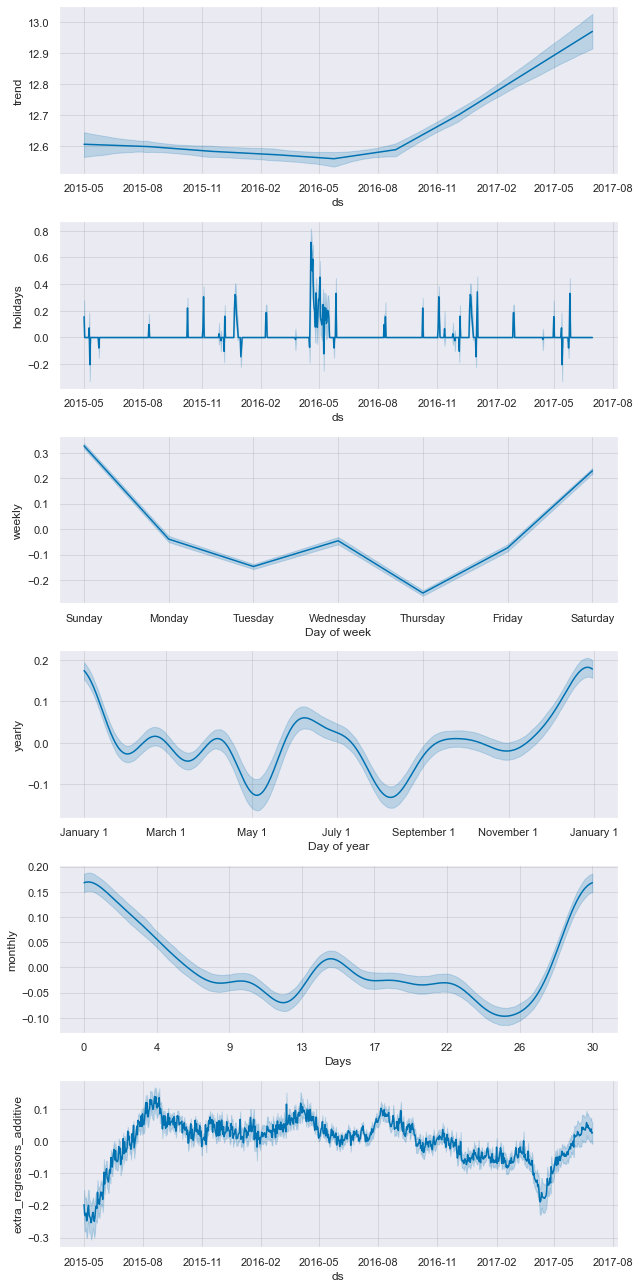

In [180]:
fig1, ax1 = plt.subplots(figsize=(10,5), dpi=120)
fig1 = m.plot(forecast, ax=ax1)
ax1.axvline(pd.to_datetime('2017-05-01'), color='k', ls='--', label='Beginning of test set')
ax1.legend(['Training data', 'Model estimate', 'Beginning of test set'])
ax1.set_ylabel('log(total sales)')
ax1.set_xlabel('date')
fig2 = m.plot_components(forecast)


In [23]:
with suppress_stdout_stderr():
    path = m.search(train, future)

        variable        kl
0   yellow_maize  0.345916
1  precipitation  2.866267
2           tmin  2.998671
3    onpromotion  3.017579
4           tavg  3.043789
5           tmax  3.156299
6      oil_price  3.482418
7       potatoes  4.684493
        variable        kl
0      oil_price  0.134466
1           tavg  0.226073
2           tmax  0.291189
3       potatoes  0.293836
4    onpromotion  0.335919
5           tmin  0.341735
6  precipitation  0.356946
        variable        kl
0           tavg  0.061415
1    onpromotion  0.112934
2           tmax  0.119008
3  precipitation  0.128876
4           tmin  0.131782
5       potatoes  0.161224
        variable        kl
0  precipitation  0.029765
1    onpromotion  0.038751
2           tmin  0.059770
3           tmax  0.060283
4       potatoes  0.064511
      variable        kl
0  onpromotion  0.008893
1     potatoes  0.024407
2         tmin  0.028878
3         tmax  0.032191
   variable        kl
0  potatoes  0.002944
1      tmin  0.008545

Text(0.5, 1.0, 'KL divergence of the best submodel for each size')

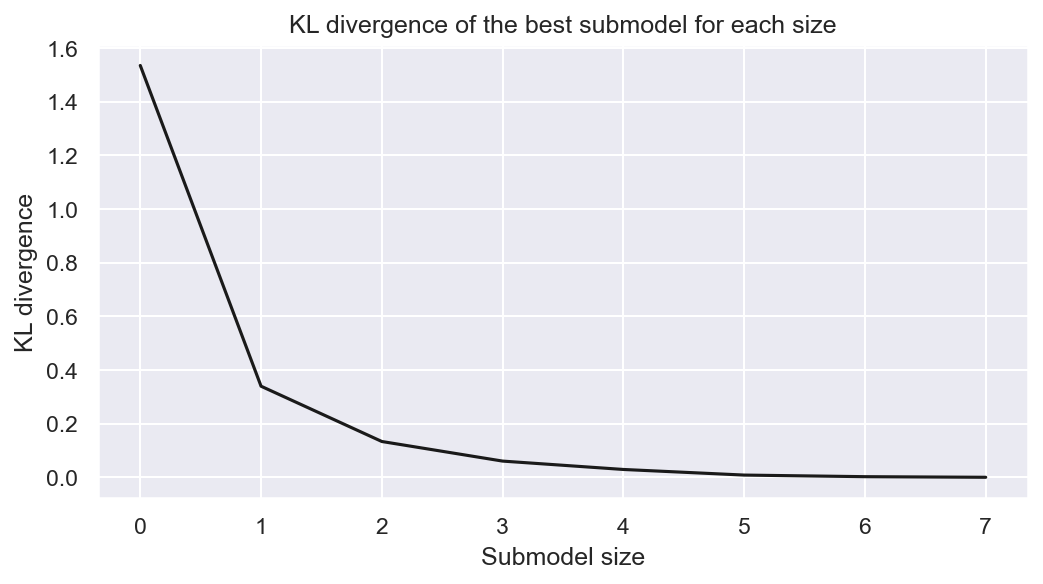

In [192]:
fig = plt.figure(facecolor='w', figsize=(8, 4), dpi=150)
ax = fig.add_subplot(111)

ax.plot([0,1,2,3,4,5,6,7], [1.535, 0.34, 0.134, 0.061, 0.0298, 0.00889, 0.00294, 0.00067], 'k')
ax.set_ylabel('KL divergence')
ax.set_xlabel('Submodel size')
ax.set_title('KL divergence of the best submodel for each size')

Regressors in the order of importance:

1. yellow maize (unit price)
2. oil price
3. average temperature
4. precipitation
5. number of items on promotion
6. potatoes (unit price)
7. maximum temperature
8. minimum temperature

In [227]:
with suppress_stdout_stderr():
    submodels = m.compute_submodels(path, train, future, ndraws_pred=20, iter=3*1e4)

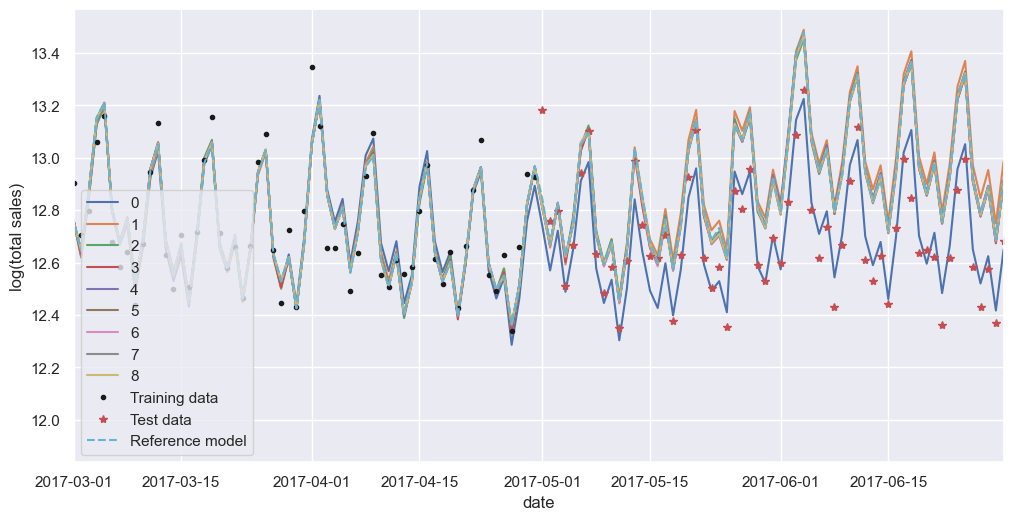

In [224]:
prophet_projpred.plot_submodels(m, submodels, future)

In [237]:
m.predict(future)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Batalla de Pichincha,Batalla de Pichincha_lower,Batalla de Pichincha_upper,Black Friday,...,yearly,yearly_lower,yearly_upper,yellow_maize,yellow_maize_lower,yellow_maize_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-05-01,12.604745,12.383761,12.617958,12.563674,12.643327,0.0,0.0,0.0,0.0,...,-0.118492,-0.154680,-0.082640,-0.122629,-0.157459,-0.087797,0.0,0.0,0.0,12.498641
1,2015-05-02,12.604673,12.613124,12.688956,12.563833,12.642956,0.0,0.0,0.0,0.0,...,-0.121837,-0.157658,-0.084000,-0.123265,-0.158276,-0.088252,0.0,0.0,0.0,12.650072
2,2015-05-03,12.604602,12.699150,12.768162,12.564247,12.642571,0.0,0.0,0.0,0.0,...,-0.124334,-0.160461,-0.086561,-0.123901,-0.159093,-0.088708,0.0,0.0,0.0,12.734000
3,2015-05-04,12.604530,12.308773,12.378983,12.564817,12.642148,0.0,0.0,0.0,0.0,...,-0.125944,-0.161671,-0.087207,-0.124537,-0.159910,-0.089163,0.0,0.0,0.0,12.344549
4,2015-05-05,12.604458,12.145229,12.219308,12.565049,12.641708,0.0,0.0,0.0,0.0,...,-0.126638,-0.162684,-0.087068,-0.125174,-0.160727,-0.089619,0.0,0.0,0.0,12.181556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,2017-06-26,12.963615,12.833373,13.020360,12.911119,13.019150,0.0,0.0,0.0,0.0,...,0.031258,0.008411,0.054247,0.022622,0.016196,0.029047,0.0,0.0,0.0,12.924492
784,2017-06-27,12.964909,12.699748,12.879405,12.912228,13.020592,0.0,0.0,0.0,0.0,...,0.029869,0.006638,0.052727,0.021541,0.015422,0.027659,0.0,0.0,0.0,12.787686
785,2017-06-28,12.966202,12.801581,12.980578,12.913128,13.022036,0.0,0.0,0.0,0.0,...,0.028537,0.005463,0.051175,0.020459,0.014648,0.026270,0.0,0.0,0.0,12.891214
786,2017-06-29,12.967496,12.599262,12.776919,12.913974,13.023712,0.0,0.0,0.0,0.0,...,0.027236,0.004719,0.049564,0.019377,0.013873,0.024881,0.0,0.0,0.0,12.688348


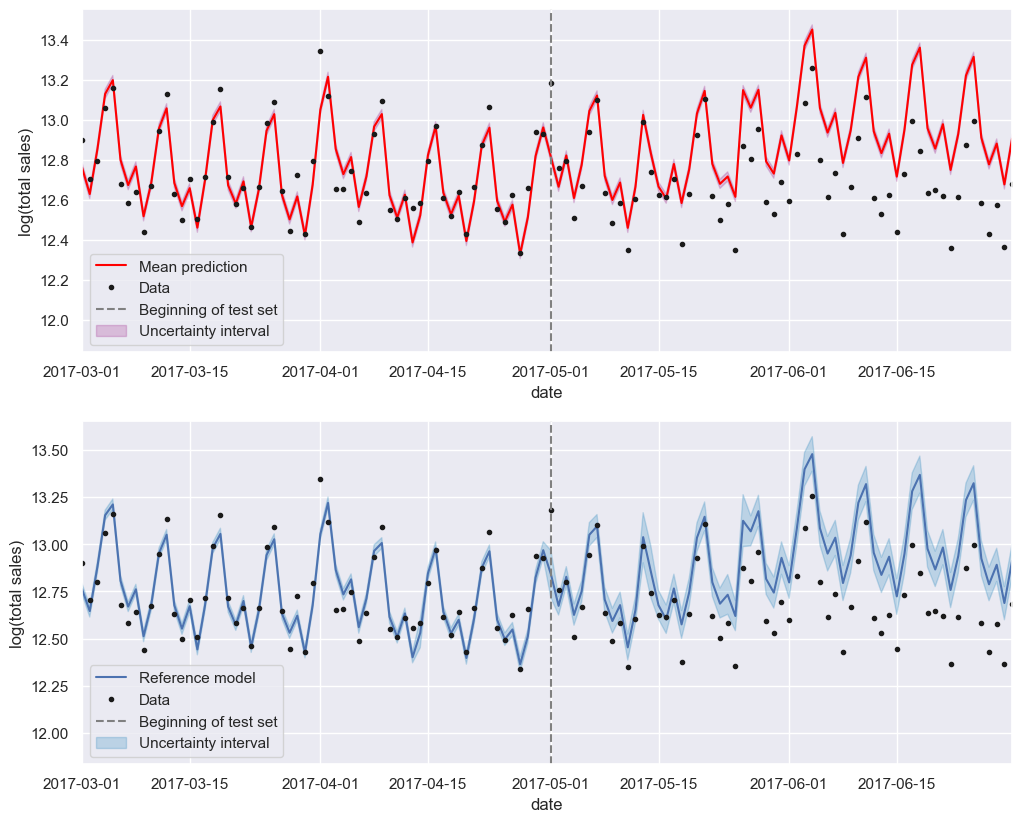

In [247]:
prophet_projpred.plots.plot_model_distribution(m, submodels[2], future)

From the above plot it is clear that the empty submodel performs best in the test set. This could be due to the reference model overfitting the increasing trend in 2017.

Noteworthy is also that the submodels quickly match the estimates of the reference model as regressors are added. This phenomenon is also clearly visible in the component plots below. 

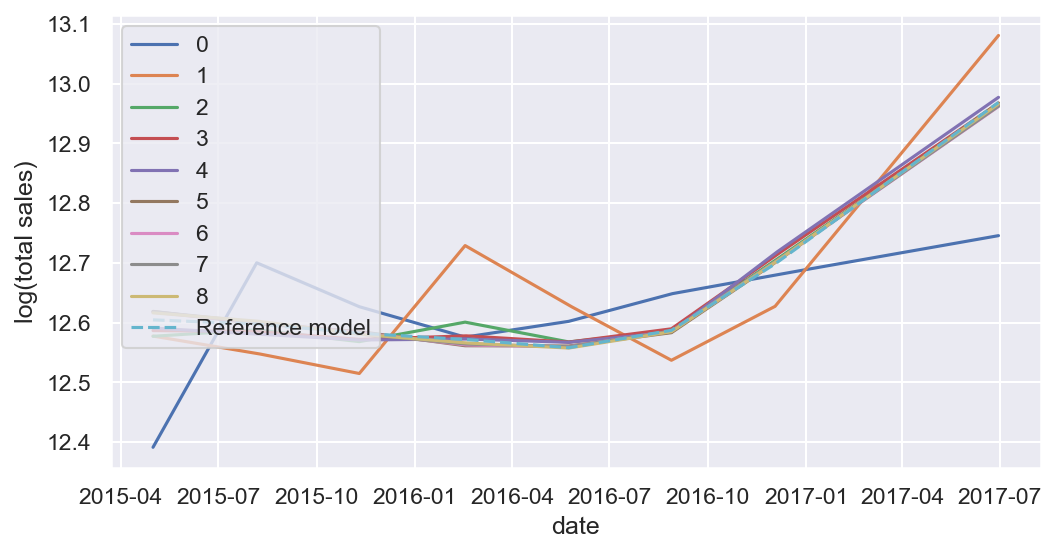

In [112]:
prophet_projpred.plot_submodel_component(m, submodels, future, 'trend')

From the third regressor onwards, Prophet essentially fits a constant trend for the first year of data and a linear, increasing trend for the second year. The subtle changes at the changepoints of the previously mentioned models could indicate that the first two regressors explain the trend rather well.

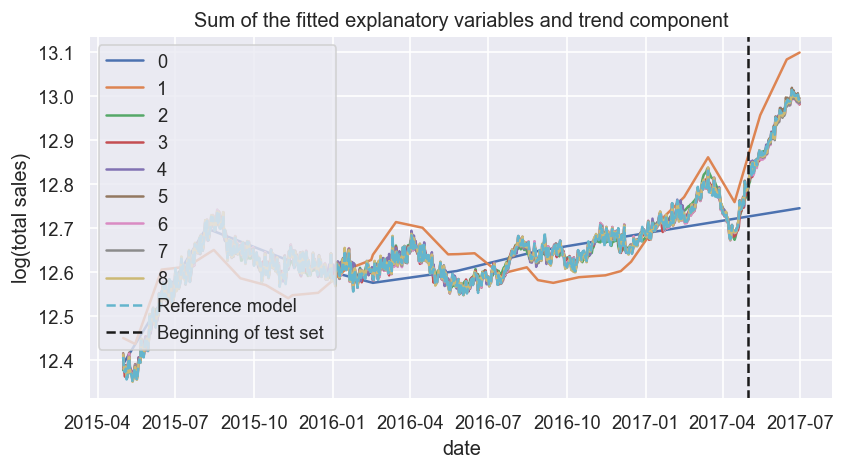

In [190]:
prophet_projpred.plot_submodel_component(m, submodels, future, 'trend_extra', 
                                         title="Sum of the fitted explanatory variables and trend component")

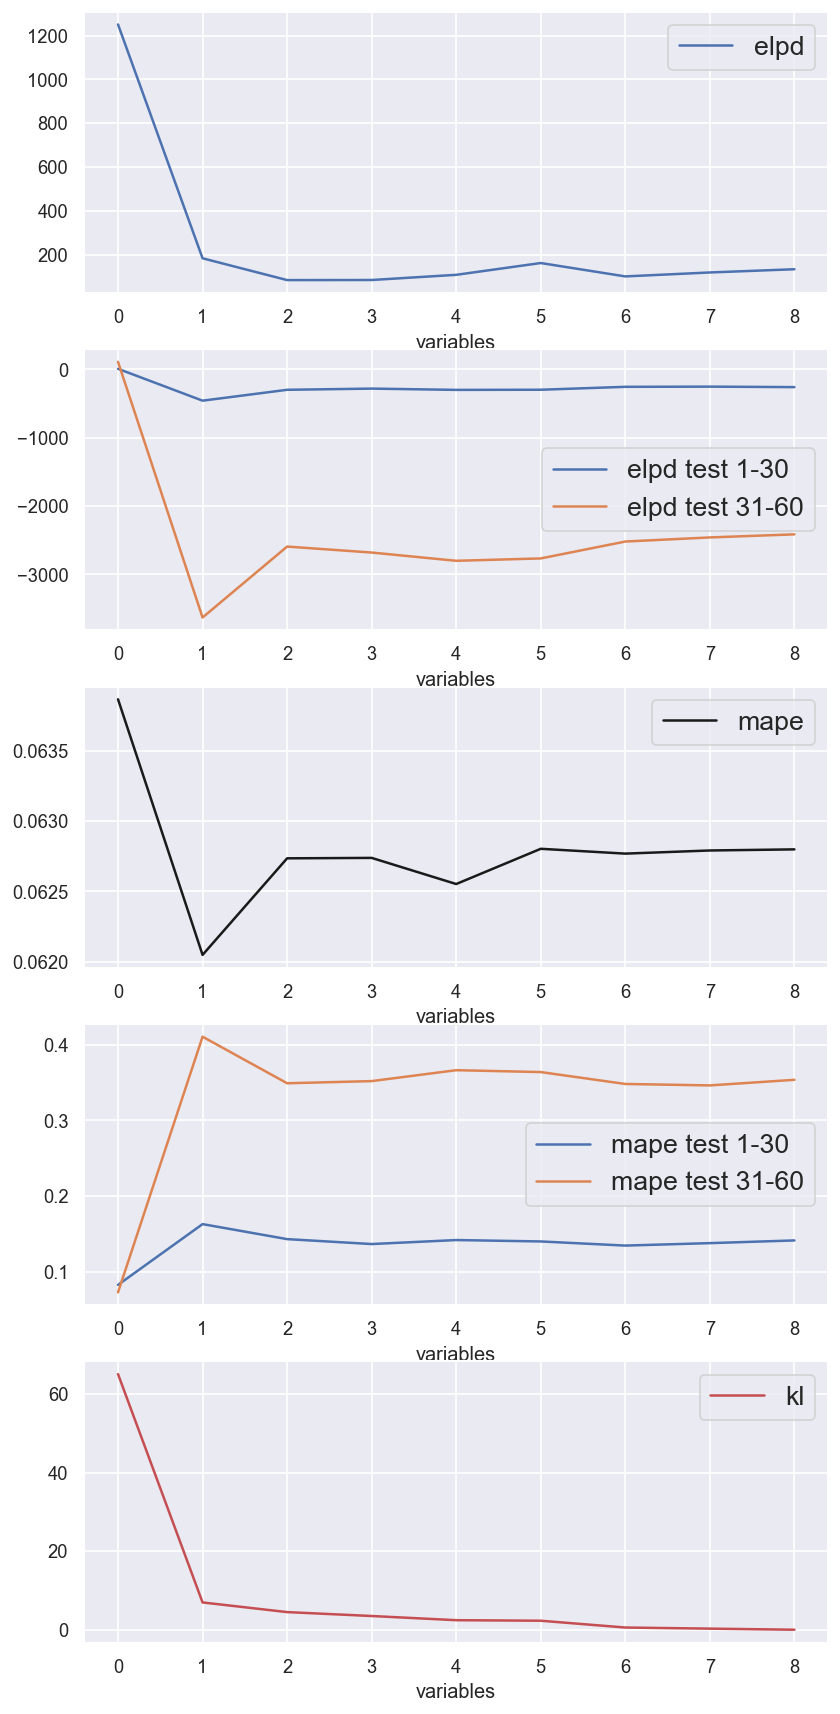

In [116]:
prophet_projpred.plot_submodel_statistics(submodels)

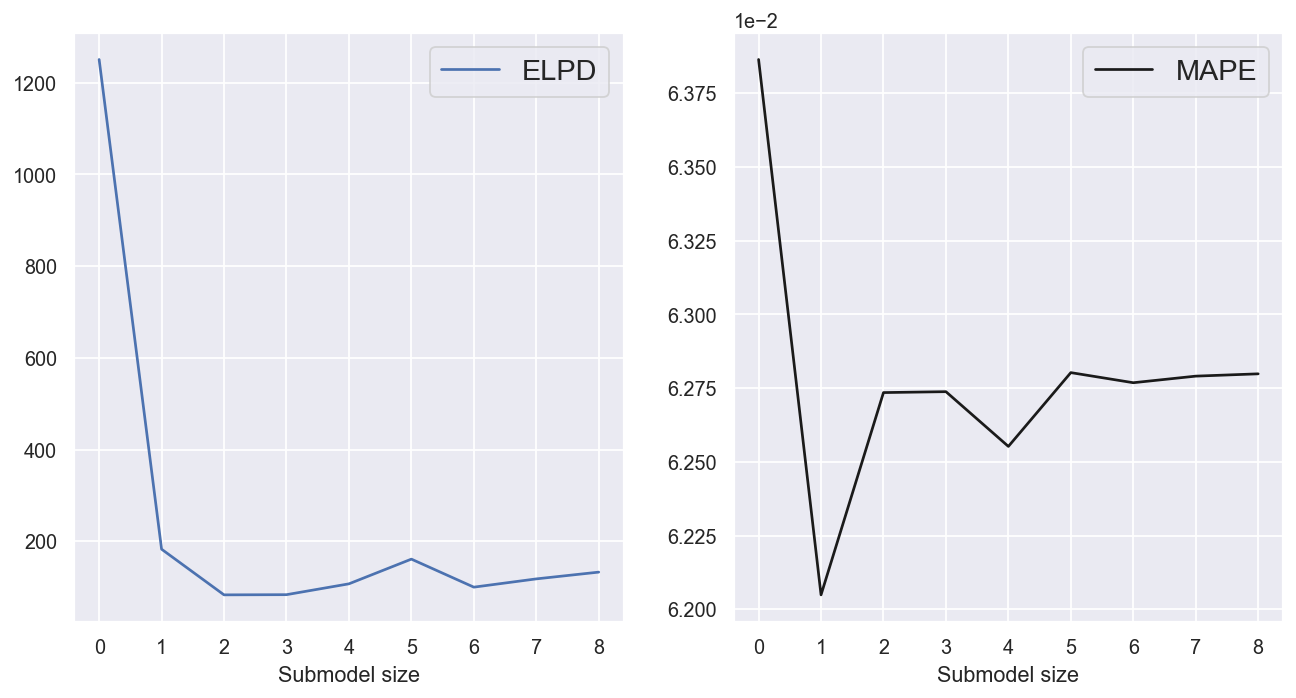

In [188]:
prophet_projpred.plots.plot_submodel_training_stats(submodels)

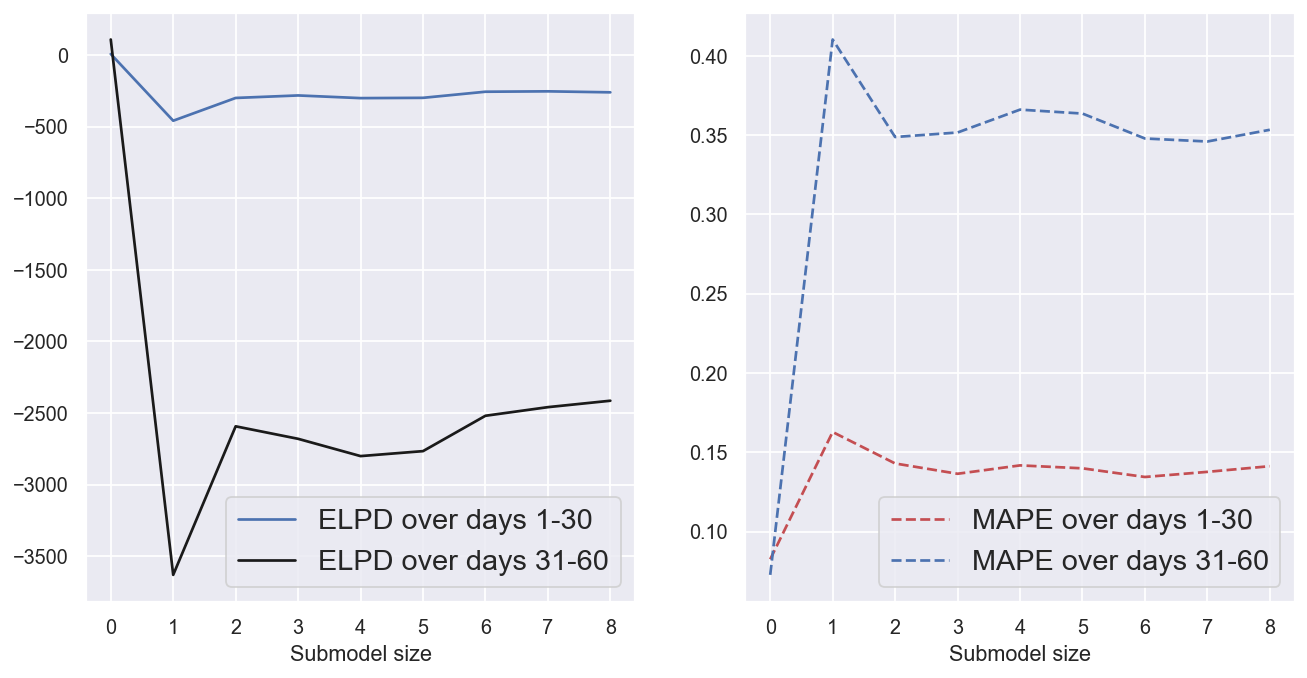

In [199]:
prophet_projpred.plots.plot_submodel_test_stats(submodels)

ELPD: larger is better

MAPE: smaller is better

In this case the statistics indicate that the reference model could be overfitting.
Simultaneously, the stats indicate that the naked Prophet model is already rather good in predicting: the model does not improve with noisy regressors.

In [89]:
for key, value in submodels.items():
    print(value['statistics']['elpd_se'])

375.4733102323028
425.5925744510467
438.2444945019506
434.17010606542243
438.72038862129733
445.3864343379955
445.38880887429514
446.06963237487156
445.1425152399259


In [90]:
for key, value in submodels.items():
    print(value['statistics']['elpd_test_se'])

114.72646501549875
177.35606936358238
377.180683435017
362.1040719435124
335.4778026801674
263.87167863187267
256.56984539634817
252.84994869448775
273.16747079520076
